**Part 2 of 2 of the modelling notebook: Decision Tree, Random Forest, kNN**

The original notebook is split into 2 parts due to its length. 
<br>This notebook involves the use of decision tree, random forest, and kNN while the previous part involves the use of topic modelling. 

A separate Excel file records certain steps and results. It serves as an experiment log, and helps the notebook to run smoother.

# Loading in libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

Continuing from the end of part 1: topic modelling:

In [21]:
# Saving the dataframe with updated topics to csv file
df.to_csv('newtopics.csv', index= False)

# Re-defining the hits

In the EDA carried out earlier, whether a song is a hit or not is determined by the mean popularity. However it is noted that a high popularity does not always result in a top 10 spot on Billboard. There is actually a lot of variation in the popularity for songs in the top 10 Billboard positions.

Hence for a more definite and concrete definition of a hit and non-hit, the Billboard ranking is used as the standard whereby any songs at rank 1-10 is considered to be a hit and any song not in the top 10 is non-hit.

In [3]:
df = pd.read_csv('/final_submission/newtopics.csv')

In [4]:
# Drop the initial hit definition
df = df.drop(columns=['hit'])

In [5]:
# Re-defining hit whereby Billboard rank 1-10 is considered to be a hit = 1
# Any song not in the top 10 is 0 for not a hit
df['hit'] = np.where(df['rank'] <= 10, 1, 0)

In [5]:
# Check
df[:11]

,year,rank,song,artist,genre,popularity,explicit,album,release_year,release_month,...,duration_m,time_signature,genre_split,lyric_pos,lyric_neu,lyric_neg,lyrics,tokens,topic,hit
0,1990,1,Hold On,Wilson Phillips,"['girl group,mellow gold,new wave pop,soft rock']",70,0,Wilson Phillips,1990,5,...,4.448,4,soft rock,0,0,1,know pain know pain lock chain chain change li...,"['know', 'pain', 'know', 'pain', 'lock', 'chai...",0,1
1,1990,2,It Must Have Been Love,Roxette,"['europop,new wave pop,soft rock,swedish pop']",75,0,It Must Have Been Love,1990,5,...,4.313,4,swedish pop,1,0,0,must love whisper pillow leave winter ground w...,"['must', 'love', 'whisper', 'pillow', 'leave',...",0,1
2,1990,3,Nothing Compares 2 U,Sinead O'Connor,"['lilith,new wave pop,pop rock']",60,0,I Do Not Want What I Haven't Got,1990,7,...,4.667,4,pop rock,0,0,1,seven hour fifteen day since take love away ev...,"['seven', 'hour', 'fifteen', 'day', 'since', '...",0,1
3,1990,4,Poison,Bell Biv DeVoe,"['boy band,contemporary r&b,hip hop,hip pop,ne...",70,0,Poison,1990,1,...,4.364,4,urban contemporary,1,0,0,spyderman freeze full effect ready ready ready...,"['spyderman', 'freeze', 'full', 'effect', 'rea...",3,1
4,1990,5,Vogue,Madonna,"['dance pop,pop']",67,0,Celebration (double disc version),1989,9,...,5.280,4,pop,1,0,0,strike pose strike pose vogue vogue vogue vogu...,"['strike', 'pose', 'strike', 'pose', 'vogue', ...",4,1
5,1990,6,Vision of Love,Mariah Carey,"['dance pop,pop,r&b,urban contemporary']",59,0,Mariah Carey,1990,6,...,3.488,3,urban contemporary,1,0,0,treat kind sweet destiny carry desperation wai...,"['treat', 'kind', 'sweet', 'destiny', 'carry',...",0,1
6,1990,7,Another Day in Paradise,Phil Collins,"['mellow gold,rock drums,soft rock']",74,0,...But Seriously (Deluxe Edition),1989,11,...,5.369,4,soft rock,1,0,0,call street help cold nowhere sleep somewhere ...,"['call', 'street', 'help', 'cold', 'nowhere', ...",0,1
7,1990,8,Hold On,En Vogue,"['contemporary r&b,dance pop,girl group,hip ho...",55,0,Born to Sing,1990,4,...,5.074,4,urban contemporary,1,0,0,treat wrong dear since since go away know hang...,"['treat', 'wrong', 'dear', 'since', 'since', '...",5,1
8,1990,9,Cradle of Love,Billy Idol,"['album rock,classic rock,dance rock,hard rock...",53,0,Charmed Life,1990,5,...,4.691,4,soft rock,1,0,0,rock cradle love rock cradle love cradle love ...,"['rock', 'cradle', 'love', 'rock', 'cradle', '...",0,1
9,1990,10,Blaze of Glory,Jon Bon Jovi,"['glam metal,hard rock']",69,0,Blaze Of Glory,1990,1,...,5.587,4,hard rock,1,0,0,wake morning raise weary head coat pillow eart...,"['wake', 'morning', 'raise', 'weary', 'head', ...",0,1


## Another brief round of EDA

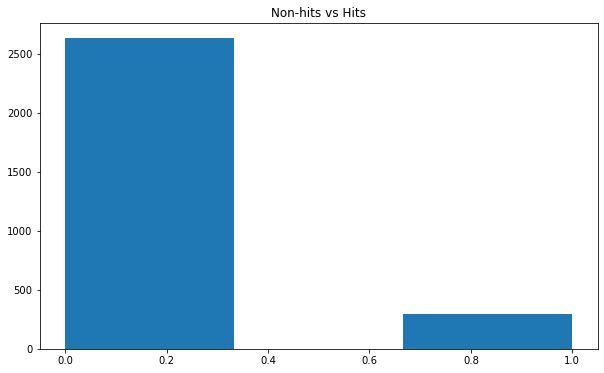

In [44]:
# Visualising the number of hits and non-hits
plt.figure(figsize=(10,6))
plt.hist(df["hit"], bins=3)
plt.title("Non-hits vs Hits")
plt.show()

In [9]:
# Get the actual counts
df['hit'].value_counts()

0    2632
1     299
Name: hit, dtype: int64

In [10]:
# Calculate the proportion of negative and positive samples
299/2632

0.11360182370820669

A baseline random classifier will give an AUROC of 0.5, but for AUPRC the baseline is equal to the fraction of positives. Therefore, on a data set with 10% positive examples, you get a baseline AUPRC of 0.1, so scoring 0.2 would be a good score, and 0.4 excellent. 

In the dataset there are 299 positive examples out of 2632 in total, so our baseline AUPRC is just 0.114. A good model could therefore have a seemingly low score.

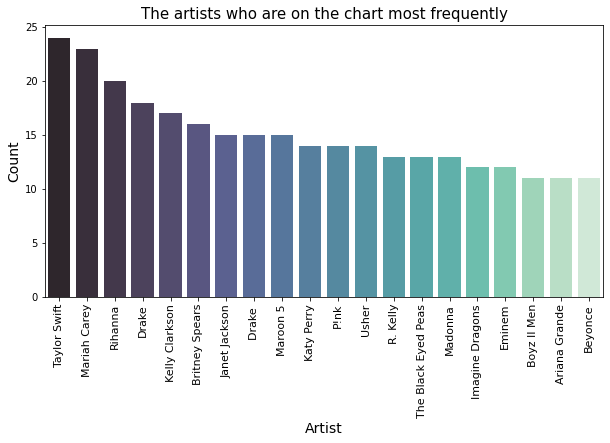

In [60]:
# Expanding on the top 10 names that appear most frequently done in previous EDA
import seaborn as sns

most_often = df['artist'].value_counts()[:20]
plt.figure(figsize=(10,5)) 
sns.barplot(x = most_often.index, y = most_often.values, alpha=0.9, palette = 'mako')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Artist', fontsize=14)
plt.title('The artists who are on the chart most frequently', fontsize=15)
plt.xticks(rotation=90, fontsize=11)
plt.show()

Some artists, like Taylor Swift or Mariah Carey have recorded more hit songs in the time frame considered than any other artist. A song typically has more chances to become a hit if the name of one of those artists is present.

### EDA for the obtained topics

In [18]:
# topics that appear the most frequently
top_topics = df['topic'].value_counts()
# Display
top_topics

0    1032
5     567
2     445
1     368
4     276
3     243
Name: topic, dtype: int64

It apeears that topic 0 about ['could', 'feel', 'life', 'heart', 'time', 'cannot', 'would', 'never', 'know', 'love'] (seems to deal with different aspects of love) is the most prevalent in the datast with no discrimination to ranking:

In [29]:
# rank with topic
frequent_topic = df[['rank','topic']].value_counts()
# Reset index name
frequent_topic = frequent_topic.reset_index(name='max') 
# Display the top 10 results
frequent_topic[:10]

,rank,topic,max
0,70,0,18
1,26,0,16
2,1,0,15
3,15,0,15
4,7,0,15
5,12,0,15
6,2,0,14
7,96,0,14
8,23,0,14
9,31,0,14


**The topic that tops the chart the most time**

In [35]:
# Filter out the songs with rank = 1/first place
hitsong = df[df['rank']==1] 
# Sum up the topics
hitsong = hitsong.groupby('topic').sum() 
# Display in descending order
hitsong[['rank']].sort_values('rank', ascending = False)

,rank
topic,
0,15
2,5
1,4
4,3
3,2
5,2


Again, topic 0 reigns the chart. 

# Decision tree

## The first model: Benchmark 

In [6]:
# Encode the artists' name
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["artist_encoded"] = le.fit_transform(df["artist"])

In [7]:
# Selecting the artists and their popularity (the barebone identifying features of a song) 
# to predict hit as benchmark
X = df[["artist_encoded", "popularity"]]
y = df["hit"]
# Default test size is 0.25 if no size is specified
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0) 

In [8]:
# Use a simple decision tree classifier with the default parameters as a benchmark :

# Fit the basic model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Calculate evaluation metrics
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_f1=f1_score(y_test, y_pred)

# Display
print('BENCHMARK DECISION TREE SCORES')
print('Accuracy:', dt_accuracy)
print('Precision:', dt_precision)
print('Recall:', dt_recall)
print('F1:', dt_f1)

BENCHMARK DECISION TREE SCORES
Accuracy: 0.8171896316507503
Precision: 0.12195121951219512
Recall: 0.1388888888888889
F1: 0.12987012987012989


The resulting F1-score is 0.13, which is low. The accuracy is high- close to 82%, but due to the data imbalance, the model tends to predict that a song is systematically not a hit, which is not an ideal evaluation metric.

## SMOTE

Synthetic Minority Oversampling Technique (SMOTE) is used to address the imbalance in the dataset whereby 
random synthetic samples are generated for the minority class [16].

In [9]:
# Dropping features that are not used for now
# At this stage, Spotify's song features are added in 
X = df.drop(['rank', 'artist', 'song', 'hit', 'year', 'genre', 'album','genre_split', 
             'lyric_pos', 'lyric_neu', 'lyric_neg', 'lyrics', 'tokens', 'topic', 
             'hit', 'artist_encoded'], axis=1)
y = df["hit"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    stratify=y, random_state=42) 
# Apply SMOTE to the training sets
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [10]:
# Value count of negative and positive samples
y_train_smote.value_counts()
# The value counts are balanced now

1    2105
0    2105
Name: hit, dtype: int64

In [12]:
# Check the number of rows before SMOTE
X_train.shape

(2344, 17)

In [11]:
# Number of rows have increased after the use of SMOTE
X_train_smote.shape

(4210, 17)

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Using back the same basic decision tree
dt2 = DecisionTreeClassifier(max_depth=100, random_state=42)
dt2.fit(X_train_smote, y_train_smote)
y_pred2 = dt2.predict(X_test)

# Create a dataframe to store the evaluation metrics
df_result = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy', 'precision', 'recall', 'f1', 'roc_auc','avg_pre'])

# Calculation of evaluation metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
roc_auc = roc_auc_score(y_test, y_pred2)
avg_precision = average_precision_score(y_test, y_pred2)

# Create a dictionary for the metrics
row = {'model': 'Tree with SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': round(accuracy,3),
        'precision': round(precision,3),
        'recall': round(recall,3),
        'f1': round(f1,3),
        'roc_auc': round(roc_auc,3),
        'avg_pre': round(avg_precision,3),
    }

# Add the row to dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147


The F1-score has improved from 0.13. The accuracy has dropped as is expected as as the data is not unbalanced anymore.

## Improved model: Random forest

While the decision tree is a good starting point, more complex models might improve overall performance. Moving on to the Random Forest Classifier with the same parameters are before:

In [11]:
# Staring with 100 trees
rf= RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)

# Calculating the evaluation metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_rf)
avg_precision = average_precision_score(y_test, y_pred_rf)

# Store the evaluation metrics in a dictionary
row = {'model': 'First Random Forest with SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }
# Append the result to the dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108


Comparing the results, while accuracy has improved, the F1 score did not. This could be due to the model is better at identifying False Positives (FP- not a hit but identified as one) but at the expense for False Negatives (FN- a hit but identified as non-hit). A smaller proportion is predicted as positve out of all the actual positive samples as indicated by the decrease in the recall and is poorer at identifying a hit as is shown by the lower precision.

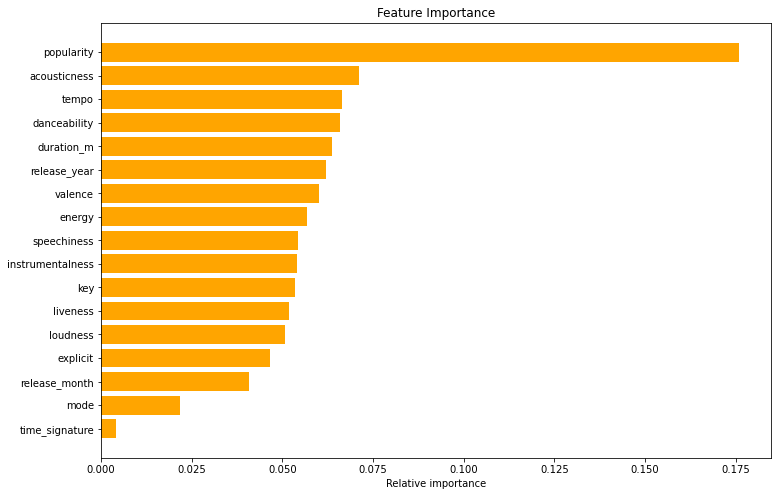

In [24]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

From the above forest, the most important feature is popularity followed by acousticness. Tempo is not too far behind while the duration round up the top 5 features.


This analysis highlights that whether a song is a hit or not has a lot to do with its tempo and danceability as well as the artist's popularity and the duration of the track.

## Adding in lyrics related features

Now, the lyrics related features such as the sentiment analyis (from the milestone stage) and topics derived earlier are added in to observe if adding in more data will improve model performance

In [12]:
# Dropping features that are not used for now
X = df.drop(['rank', 'artist', 'song', 'hit', 'year', 'genre', 'album','genre_split', 
             'lyrics', 'tokens', 'hit', 'artist_encoded'], axis=1)
y = df["hit"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    stratify=y, random_state=42) 
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [13]:
# Still 100 trees
rf2= RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit(X_train_smote, y_train_smote)
y_pred_rf2 = rf2.predict(X_test)

# Evaluation metrics calculation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf2).ravel()
accuracy = accuracy_score(y_test, y_pred_rf2)
precision = precision_score(y_test, y_pred_rf2)
recall = recall_score(y_test, y_pred_rf2)
f1 = f1_score(y_test, y_pred_rf2)
roc_auc = roc_auc_score(y_test, y_pred_rf2)
avg_precision = average_precision_score(y_test, y_pred_rf2)

# Store the metrics in a dictionary
row = {'model': 'Random Forest with lyrical features, SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }
# Append the dictionary to the dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103


While accuracy continues to improve, F1 did not. The classifier is still prone to Type II error with more FN. 

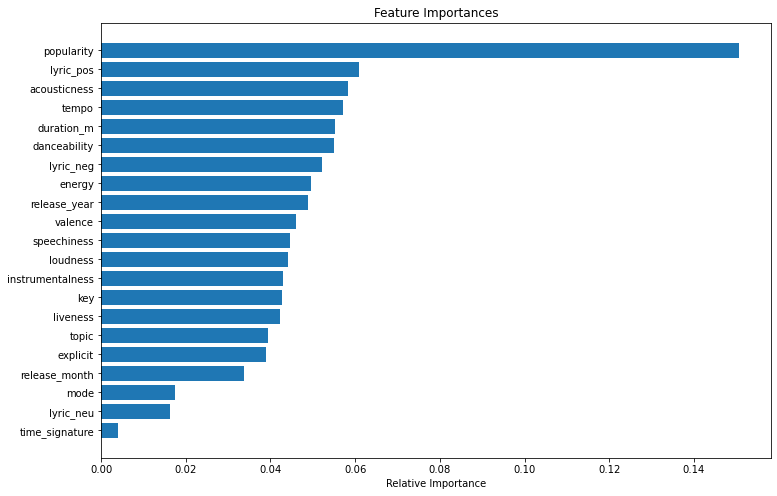

In [29]:
# Visualising feature importances
importances = rf2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

After adding in the lyrics related features, artists popularity remains the most important feature. But now instead of acousticness, lyric with positive sentiment is taking the second spot. Here, duration of a track rounds up the top 5 ranking and is deemed to be more important than danceability.

## Applying under and over sampling simultaneously 

In actual real world ranking, there will not be an equal number of hits and non-hits. Hence the Random Under Sampler (RUS) class is used to randomly under sample the majority class [17].

In [14]:
X = df.drop(['rank', 'artist', 'song', 'hit', 'year', 'genre', 'album','genre_split', 
             'lyrics', 'tokens', 'hit', 'artist_encoded'], axis=1)
y = df["hit"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    stratify=y, random_state=42) 

# Apply SMOTE with a sampling strategy to oversample the minority class 
# so it represents 55% of the total
# k_neighbors argument to define the number of neighbours to use when creating the data
sm = SMOTE(random_state=42, sampling_strategy=0.55, k_neighbors=4)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [1]:
# Initial shape
y_train.shape

In [19]:
# Initial count of negatives and positives
y_train.value_counts()

0    2105
1     239
Name: hit, dtype: int64

In [20]:
# Checking the value count of positives and negatives
y_train_smote.value_counts()

0    2105
1    1157
Name: hit, dtype: int64

In [15]:
# Apply under sampling to the over sampled data with a sampling strategy
# such that the majority exceeds the minority by 55%
rus = RandomUnderSampler(sampling_strategy=0.55, random_state=42)
X_train_final, y_train_final = rus.fit_resample(X_train_smote, y_train_smote)

In [22]:
y_train_final.value_counts()

0    2103
1    1157
Name: hit, dtype: int64

After trying some different combinations, the positive samples (or hit) make up about 35% while negative samples around 65%. This proportion is not as severely imbalanced as the inital counts, neither is it ideally euqally balanced.

In [16]:
# Using back the same forest with 100 trees but fit with SMOTE/RUS training data
rf3= RandomForestClassifier(n_estimators=100, random_state=42)
rf3.fit(X_train_final, y_train_final)
y_pred_rf3 = rf3.predict(X_test)

# Evaluation metrics calculation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf3).ravel()
accuracy = accuracy_score(y_test, y_pred_rf3)
precision = precision_score(y_test, y_pred_rf3)
recall = recall_score(y_test, y_pred_rf3)
f1 = f1_score(y_test, y_pred_rf3)
roc_auc = roc_auc_score(y_test, y_pred_rf3)
avg_precision = average_precision_score(y_test, y_pred_rf3)


# Store the metrics in a dictionary
row = {'model': 'Random Forest with lyrical features, SMOTE/RUS',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

# Add the dictionary to the dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11


There is some slight improvement- the number of both types of classification errors have reduced, and the model is better at identifying positive samples and idetnifying such samples correctly as indicated by an increase in recall and precision respectively. 

## Hyperparameter tuning

The tuning strategy for random forest is to first randomly sample from a grid of hyperparameters, which are then optimized by cross validation Randomnized Search [18]. After the hyperparameters have been narrowed down, Grid Search will be used to try out all the parameter values [18]. This is done to work around the computational time and resources needed.

The hyperparameters tuned are mostly to the trees and the way they split such as the number of trees, their depth, the leaf size. The data has not been normalised thus far as random forest is a tree-based model instead of a distance based model (like the KNN; the data will be normalised at that section). It works by partitioning the data to make predictions, hence normalisation will not have much affect on it [19, 20].

### Randomized Search

In [212]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(10, 100, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [213]:
# Checking the parameters are as expected
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 65, 80, 95, 110, 125, 140, 155, 170, 185, 200]}


In [ ]:
# Use the random_grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_final, y_train_final)

# Output will be cleared to maintain notebook's length. But some will be recorded
# in the experiment log

In [215]:
# Out come of fitting 5 folds for each of 100 candidates, totalling 500 fits
rf_random.best_params_

{'n_estimators': 65,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

### Randomized search evaluation

In [17]:
# With the tuned hyperparameters
rf_rand= RandomForestClassifier(n_estimators=65, min_samples_split=10, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=60, bootstrap=False, random_state=42)
rf_rand.fit(X_train_final, y_train_final)
y_pred_rand = rf_rand.predict(X_test)

# Evaluation metrics calculation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rand).ravel()
accuracy = accuracy_score(y_test, y_pred_rand)
precision = precision_score(y_test, y_pred_rand)
recall = recall_score(y_test, y_pred_rand)
f1 = f1_score(y_test, y_pred_rand)
roc_auc = roc_auc_score(y_test, y_pred_rand)
avg_precision = average_precision_score(y_test, y_pred_rand)

# From here on out RF = random forest to keep the length of model name in check
# Store the metrics in a dictionary
row = {'model': 'SMOTE/RUS RF, Random Search',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }
# Adding the dictionary to the dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11
4,"SMOTE/RUS RF, Random Search",4,500,27,56,504,83,0.858603,0.129032,0.066667,0.087912,0.507717,0.104


The evaluation metrics dipped instead of improving and there are more FP errors too. Next, Grid Search will be used to see if narrowing down the range will see improvement:

### Grid Search CV

In [19]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [False],
              'max_depth': [55, 60, 65, 70, 80],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [10, 20, 30],
              'min_samples_split': [2, 4, 6, 8, 12],
              'n_estimators': [55, 60, 62, 64, 66, 68, 70]}

# Create a base model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train_final, y_train_final)
grid_search.best_params_

# Output will be cleared for length but some will be recored in experiment log

In [22]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 55,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 70}

In [18]:
# With Grid Search's hyperparameters
rf_grid= RandomForestClassifier(n_estimators=70, min_samples_split=2, min_samples_leaf=10, 
                           max_features='auto', max_depth=55, bootstrap=False, random_state=42)
rf_grid.fit(X_train_final, y_train_final)
y_pred_grid = rf_grid.predict(X_test)

# Calculation of evaluation metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_grid).ravel()
accuracy = accuracy_score(y_test, y_pred_grid)
precision = precision_score(y_test, y_pred_grid)
recall = recall_score(y_test, y_pred_grid)
f1 = f1_score(y_test, y_pred_grid)
roc_auc = roc_auc_score(y_test, y_pred_grid)
avg_precision = average_precision_score(y_test, y_pred_grid)

# RF = random forest 
# Storing the metrics into a dictionary
row = {'model': 'SMOTE/RUS RF, Grid Search',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

# Adding the dictionary to the dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11
4,"SMOTE/RUS RF, Random Search",4,500,27,56,504,83,0.858603,0.129032,0.066667,0.087912,0.507717,0.104
5,"SMOTE/RUS RF, Grid Search",4,498,29,56,502,85,0.855196,0.121212,0.066667,0.086022,0.505819,0.103


There is no improvement after Grid Search. Based on the evaluation metrics and the number of classification errors, it appears that the Random Forest classifier built with the lyrics and related data added in performed the best (scoring the highest over all, and with fewest mistakes made)  and will be considered as the final version for the random forest classifier.

## AUC Comparisons

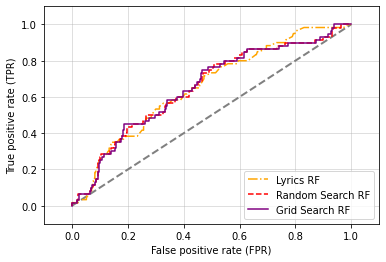

In [29]:
# Plotting dataset with lyrics added in Random Forest's ROC curve
y_pred_prob1 = rf2.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

# Plotting Randomized Search Random Forest's ROC curve
y_pred_prob2 = rf_rand.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

# Plotting Grid Search Random Forest's ROC curve
y_pred_prob3 = rf_grid.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)


plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.plot(fpr1, tpr1,
        color= 'orange',
        linestyle= '-.',
        label= 'Lyrics RF')

plt.plot(fpr2, tpr2,
        color= 'red',
        linestyle= '--',
        label= 'Random Search RF')

plt.plot(fpr3, tpr3,
        color= 'purple',
        linestyle= '-',
        label= 'Grid Search RF')


plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()

The ROC curves are all very close together. However, as the threshold decreases, lyrics RF are better at identifying the positive samples than the other two random forest classifiers as the True Positive Rate (or recall) is higher than the other 2 curves.

Text(0.5, 1.0, 'Precision-Recall curve')

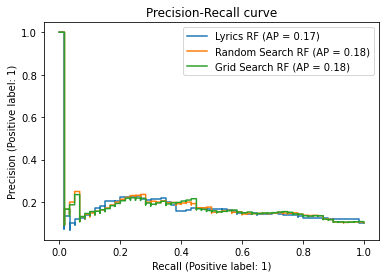

In [30]:
# Plotting precision-recall curves
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(rf2, X_test, y_test, ax = plt.gca(),name = "Lyrics RF")
plot_precision_recall_curve(rf_rand, X_test, y_test, ax = plt.gca(),name = "Random Search RF")
plot_precision_recall_curve(rf_grid, X_test, y_test, ax = plt.gca(),name = "Grid Search RF")

plt.legend(loc='upper right')
plt.title('Precision-Recall curve')

Looking at the Precision-Recall curves, there is a sharp drop in precision very early on, which could be possibly caused by the data balance. When recall is low, Random Search and Grid Search RF have higher precision. But as recall increases, lyrics RF start to perform better. 

In [19]:
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11
4,"SMOTE/RUS RF, Random Search",4,500,27,56,504,83,0.858603,0.129032,0.066667,0.087912,0.507717,0.104
5,"SMOTE/RUS RF, Grid Search",4,498,29,56,502,85,0.855196,0.121212,0.066667,0.086022,0.505819,0.103


Looking at the above results again, the average precision is marginally higher for Random Forest with lyrical features, SMOTE/RUS (lyrics RF) as compared to both searches. As such, the reasons stated before th AUC comparison still stand, and lyrics RF is the best performing random forest classifier out all that had been compared.

In [32]:
# Saving the dataframe with model evaluation results to csv file
df_result.to_csv('evaluations.csv', index= False)

# KNN

## SMOTE

In [7]:
# Dropping features that are not used for now
X = df.drop(['rank', 'artist', 'song', 'hit', 'year', 'genre', 'album','genre_split', 
             'lyrics', 'tokens', 'hit', 'artist_encoded'], axis=1)
y = df["hit"]

# Train-test split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    stratify=y, random_state=42) 
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_smote_k, y_train_smote_k = sm.fit_resample(X_train_knn, y_train_knn)

In [67]:
# Before using SMOTE
y_train.shape

(2344,)

In [22]:
# After using
y_train_smote_k.shape

(4210,)

### Normalising X_train_smote

In [8]:
# Dropping the columns that do not need scaling
X_train_drop= X_train_smote_k.drop(columns=['explicit', 'lyric_pos', 'lyric_neu', 'lyric_neg'])

In [9]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler
scaler = MinMaxScaler()
# Fitting the scaler and transform the values in dataframe
X2 = scaler.fit_transform(X_train_drop)

In [10]:
# Create a new dataframe for the scaled arrays
X_df= pd.DataFrame(X2, columns=X_train_drop.iloc[:,:].columns)

In [11]:
# Checking the shape of new dataframe
X_df.shape

(4210, 17)

In [12]:
# Reset index of X_train for the concatenation next
X_train_smote_k = X_train_smote_k.reset_index(drop=True)

In [13]:
# Concatenate the scaled data with those that do not need scaling
X_train2 = pd.concat([X_df, X_train_smote_k['explicit'], X_train_smote_k['lyric_pos'], 
                      X_train_smote_k['lyric_neu'], X_train_smote_k['lyric_neg']],axis= "columns")

In [14]:
# Checking shape that the concatenation was successful
X_train2.shape

(4210, 21)

In [30]:
y_train_smote_k.shape

(4210,)

### For X_test

In [15]:
# Initial shape
X_test_knn.shape

(587, 21)

In [16]:
# Dropping the columns that do not need scaling
X_test_drop= X_test_knn.drop(columns=['explicit', 'lyric_pos', 'lyric_neu', 'lyric_neg'])

In [33]:
# Check if number of columns as expected after dropping
X_test_drop.shape

(587, 17)

In [17]:
# Transform dataframe with the already fitted scaler
X_test_scaled = scaler.transform(X_test_drop)

In [18]:
# Create a new dataframe for the arrays with corresponding column names
X_test_df= pd.DataFrame(X_test_scaled, columns=X_test_drop.iloc[:,:].columns)

In [19]:
# Reset index of X_test for the concatenation next
X_test_knn = X_test_knn.reset_index(drop=True)

In [20]:
# Concatenate the scaled data with those that do not need scaling
X_test2 = pd.concat([X_test_df, X_test_knn['explicit'], X_test_knn['lyric_pos'], 
                     X_test_knn['lyric_neu'], X_test_knn['lyric_neg']],axis= "columns")

In [21]:
# Shape check that the concatenation was successful
X_test2.shape

(587, 21)

## SMOTE/RUS

With the same sampling strategies for SMOTE and RUS used in Random Forest

In [25]:
X = df.drop(['rank', 'artist', 'song', 'hit', 'year', 'genre', 'album','genre_split', 
             'lyrics', 'tokens', 'hit', 'artist_encoded'], axis=1)
y = df["hit"]

# Train-test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    stratify=y, random_state=42) 

# Apply SMOTE
sm = SMOTE(random_state=42, sampling_strategy=0.55, k_neighbors=4)
X_train_smote2, y_train_smote2 = sm.fit_resample(X_train_2, y_train_2)

In [26]:
# Apply RUS
rus = RandomUnderSampler(sampling_strategy=0.55, random_state=42)
X_train_final_knn, y_train_final_knn = rus.fit_resample(X_train_smote2, y_train_smote2)

### Normalisation

In [27]:
# Number of rows and columns of initial X_train set
X_train_final_knn.shape

(3260, 21)

In [28]:
# Dropping the columns that do not need scaling
X_train_drop2= X_train_final_knn.drop(columns=['explicit', 'lyric_pos', 'lyric_neu', 'lyric_neg'])

In [29]:
# MinMaxScaler
scaler = MinMaxScaler()
# Fitting the scaler and transform the values in dataframe
X_knn = scaler.fit_transform(X_train_drop2)

In [30]:
# Create a new dataframe for the scaled arrays
X_knn_df= pd.DataFrame(X_knn, columns=X_train_drop2.iloc[:,:].columns)

In [31]:
# Checking the shape of new dataframe
X_knn_df.shape

(3260, 17)

In [32]:
# Reset index of X_train for the concatenation next
X_train_final_knn = X_train_final_knn.reset_index(drop=True)

In [33]:
# Concatenate the scaled data with those that do not need scaling
X_train_final2 = pd.concat([X_knn_df, X_train_final_knn['explicit'], X_train_final_knn['lyric_pos'], 
                      X_train_final_knn['lyric_neu'], X_train_final_knn['lyric_neg']],axis= "columns")

In [54]:
# Checking shape that the concatenation was successful
X_train_final2.shape

(3260, 21)

### X_test

In [51]:
# Initial shape
X_test_2.shape

(587, 21)

In [34]:
# Dropping the columns that do not need scaling
X_test2_drop= X_test_2.drop(columns=['explicit', 'lyric_pos', 'lyric_neu', 'lyric_neg'])

In [35]:
# Check if number of columns as expected after dropping
X_test2_drop.shape

(587, 17)

In [36]:
# Transform dataframe with the already fitted scaler
X_test_scaled2 = scaler.transform(X_test2_drop)

In [37]:
# Create a new dataframe for the arrays with corresponding column names
X_test2_df= pd.DataFrame(X_test_scaled2, columns=X_test2_drop.iloc[:,:].columns)

In [38]:
# Reset index of X_test for the concatenation next
X_test_2 = X_test_2.reset_index(drop=True)

In [39]:
# Concatenate the scaled data with those that do not need scaling
X_test2_final = pd.concat([X_test2_df, X_test_2['explicit'], X_test_2['lyric_pos'], 
                     X_test_2['lyric_neu'], X_test_2['lyric_neg']],axis= "columns")

In [62]:
# Shape check that the concatenation was successful
X_test2_final.shape

(587, 21)

## Modelling

### SMOTE BENCHMARK

In [24]:
# Using a Dummy Classifier as baseline

from sklearn.dummy import DummyClassifier
dummy_sm = DummyClassifier(random_state=42)
dummy_sm.fit(X_train2, y_train_smote_k)
dummy_pred = dummy_sm.predict(X_test2)

# Calculate evaluation metrics
dummy_sm_accuracy = accuracy_score(y_test_knn, dummy_pred)
dummy_sm_precision = precision_score(y_test_knn, dummy_pred)
dummy_sm_recall = recall_score(y_test_knn, dummy_pred)
dummy_sm_f1=f1_score(y_test_knn, dummy_pred)

# Display
print('DUMMY CLASSIFIER SCORES')
print('Accuracy:', dummy_sm_accuracy)
print('Precision:', dummy_sm_precision)
print('Recall:', dummy_sm_recall)
print('F1:', dummy_sm_f1)

DUMMY CLASSIFIER SCORES
Accuracy: 0.8977853492333902
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/onion/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SMOTE/RUS BENCHMARK

In [40]:
dummy_2 = DummyClassifier(random_state=42)
dummy_2.fit(X_train_final2, y_train_final_knn)
dummy2_pred = dummy_2.predict(X_test2_final)

# Calculate evaluation metrics
dummy_2_accuracy = accuracy_score(y_test_2, dummy2_pred)
dummy_2_precision = precision_score(y_test_2, dummy2_pred)
dummy_2_recall = recall_score(y_test_2, dummy2_pred)
dummy_2_f1=f1_score(y_test_2, dummy2_pred)

# Display
print('DUMMY CLASSIFIER WITH SMOTE/RUS SCORES')
print('Accuracy:', dummy_2_accuracy)
print('Precision:', dummy_2_precision)
print('Recall:', dummy_2_recall)
print('F1:', dummy_2_f1)

DUMMY CLASSIFIER WITH SMOTE/RUS SCORES
Accuracy: 0.8977853492333902
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/onion/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Grid Search for optimal number of k (SMOTE)

In [40]:
from sklearn.model_selection import GridSearchCV
# Create new a knn model
knn_sm = KNeighborsClassifier()
# Create a dictionary of all values to be tested for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
# Use gridsearch to test all values for n_neighbors 
# with 5 fold cross validation
knn_gscv_sm = GridSearchCV(knn_sm, param_grid, cv=5)
# Fit model 
knn_gscv_sm.fit(X_train2, y_train_smote_k)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [41]:
# Check optimal number of k
knn_gscv_sm.best_params_

{'n_neighbors': 2}

In [42]:
# Mean score for best number of k
knn_gscv_sm.best_score_

0.8845605700712589

## Grid Search for optimal number of k (SMOTE/RUS)

In [73]:
# Create new a knn model
knn2 = KNeighborsClassifier()
# Create a dictionary of all to be tested test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
# Use gridsearch to test all values for n_neighbors with 
# 5 fold cross validation
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
# Fit model to data
knn_gscv.fit(X_train_final2, y_train_final_knn)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [74]:
# Optimal number of k
knn_gscv.best_params_

{'n_neighbors': 2}

In [75]:
# Mean score for the best params
knn_gscv.best_score_

0.8723926380368099

In [76]:
# The cross validation scores can be examined in depth
knn_gscv.cv_results_

{'mean_fit_time': array([0.00151892, 0.00086722, 0.00083857, 0.00085216, 0.00089331,
        0.0008708 , 0.00084734, 0.00084624, 0.00087199, 0.00083876,
        0.00080571, 0.00083179, 0.00083814, 0.00089483, 0.00081687,
        0.00081735, 0.0008451 , 0.00082679, 0.00085335, 0.00083179,
        0.00084858, 0.00086832, 0.00085325, 0.00080724]),
 'std_fit_time': array([1.18332916e-03, 4.37643523e-05, 4.83970689e-05, 2.60496275e-05,
        5.58000132e-05, 3.26257684e-05, 4.55021093e-05, 2.37350934e-05,
        4.92392033e-05, 4.01314492e-05, 3.06055916e-05, 5.88578939e-05,
        7.90829216e-05, 4.10947879e-05, 4.45209655e-05, 3.17622946e-05,
        9.49085640e-06, 2.35677218e-05, 4.30466445e-05, 3.49773626e-05,
        3.85505665e-05, 3.30028501e-05, 1.53926107e-05, 4.77176545e-05]),
 'mean_score_time': array([0.22850494, 0.27645493, 0.23332376, 0.24900827, 0.29491305,
        0.25657001, 0.24541845, 0.31066637, 0.22802639, 0.24459763,
        0.23569708, 0.20787797, 0.27918377, 0.23

In [77]:
#df_result = pd.read_csv('/Users/onion/Downloads/NYP/Project/Modelling/evaluations.csv')

## Tuned KNN

Since for the both times Grid Search are performed the optimal number of k has been returned as 2, that will be the value used for the tuned model:

In [63]:
#from sklearn.neighbors import KNeighborsClassifier
# With best params from tuning
knn_tuned = KNeighborsClassifier(n_neighbors=2)
knn_tuned.fit(X_train_final2, y_train_final_knn)
y_pred_knn = knn_tuned.predict(X_test2_final)

# Evaluation metrics calculation
tn, fp, fn, tp = confusion_matrix(y_test_2, y_pred_knn).ravel()
accuracy = accuracy_score(y_test_2, y_pred_knn)
precision = precision_score(y_test_2, y_pred_knn)
recall = recall_score(y_test_2, y_pred_knn)
f1 = f1_score(y_test_2, y_pred_knn)
roc_auc = roc_auc_score(y_test_2, y_pred_knn)
avg_precision = average_precision_score(y_test_2, y_pred_knn)

# Store metrics in a dictionary
row = {'model': 'SMOTE/RUS KNN, Grid Search',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }
# Add dictionary to dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11
4,"SMOTE/RUS RF, Random Search",4,500,27,56,504,83,0.858603,0.129032,0.066667,0.087912,0.507717,0.104
5,"SMOTE/RUS RF, Grid Search",4,498,29,56,502,85,0.855196,0.121212,0.066667,0.086022,0.505819,0.103
6,"SMOTE/RUS KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121
7,"SMOTE KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121
8,"SMOTE/RUS KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121


In [62]:
#from sklearn.neighbors import KNeighborsClassifier
# With tuned params
knn_sm_tuned = KNeighborsClassifier(n_neighbors=2)
knn_sm_tuned.fit(X_train2, y_train_smote_k)
y_pred_knn_sm = knn_sm_tuned.predict(X_test2)

# Evaluation metrics calculation
tn, fp, fn, tp = confusion_matrix(y_test_knn, y_pred_knn).ravel()
accuracy = accuracy_score(y_test_knn, y_pred_knn)
precision = precision_score(y_test_knn, y_pred_knn)
recall = recall_score(y_test_knn, y_pred_knn)
f1 = f1_score(y_test_knn, y_pred_knn)
roc_auc = roc_auc_score(y_test_knn, y_pred_knn)
avg_precision = average_precision_score(y_test_knn, y_pred_knn)

# Store values into a dictionary
row = {'model': 'SMOTE KNN, Grid Search',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }
# Add dictionary into dataframe
df_result = df_result.append(row, ignore_index=True)
# Display
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11
4,"SMOTE/RUS RF, Random Search",4,500,27,56,504,83,0.858603,0.129032,0.066667,0.087912,0.507717,0.104
5,"SMOTE/RUS RF, Grid Search",4,498,29,56,502,85,0.855196,0.121212,0.066667,0.086022,0.505819,0.103
6,"SMOTE/RUS KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121
7,"SMOTE KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121


Whether it be using SMOTE or SMOTE and RUS, there is no difference in the performance. Both of them also perform better than the 2 dummy classifiers as the dummies were not able to identify the positive samples. SMOTE/RUS KNN, Grid Search will be used to compare against Random Forest with lyrical features, SMOTE/RUS as both had SMOTE and RUS applied to the data.

# Final model comparison

## ROC AUC 

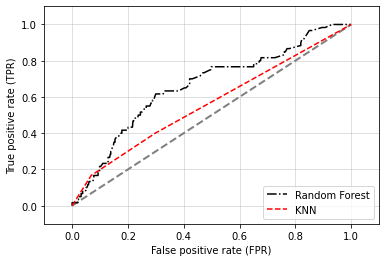

In [65]:
# Plotting Random Forest's ROC curve
y_pred_prob1 = rf3.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

# Plotting KNN's ROC curve
y_pred_prob2 = knn_tuned.predict_proba(X_test2_final)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test_2, y_pred_prob2)


plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)


plt.plot(fpr1, tpr1,
        color= 'black',
        linestyle= '-.',
        label='Random Forest')

plt.plot(fpr2, tpr2,
        color= 'red',
        linestyle= '--',
        label='KNN')

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()

From the above plot, lyrics RF has a higher AOC than KNN. Indeed, looking at evaluation metrics dataframe from above, the lyrics RF has an advantage in identifying fewer FP (20 as compared to KNN's 36).

## Precision-recall curve

Text(0.5, 1.0, 'Precision-Recall curve')

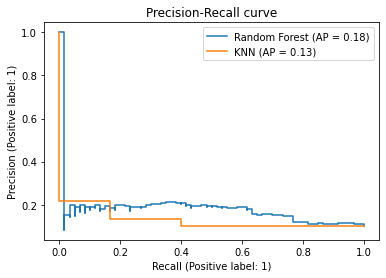

In [67]:
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

# Plotting precision-recall curves
plot_precision_recall_curve(rf3, X_test, y_test, ax = plt.gca(),name = "Random Forest")
plot_precision_recall_curve(knn_tuned, X_test2_final, y_test_2, ax = plt.gca(),name = "KNN")

plt.legend(loc='upper right')
plt.title('Precision-Recall curve')

Over here, the Precision-Recall curve shows the lyrics Random Forest has higher AUC than KNN. Referring to the outcome dataframe for the rest of the evaluation metrics:

In [68]:
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,Tree with SMOTE,26,427,100,34,453,134,0.772,0.206,0.433,0.28,0.622,0.147
1,First Random Forest with SMOTE,8,480,47,52,488,99,0.831346,0.145455,0.133333,0.13913,0.522075,0.108
2,"Random Forest with lyrical features, SMOTE",4,495,32,56,499,88,0.850085,0.111111,0.066667,0.083333,0.502973,0.103
3,"Random Forest with lyrical features, SMOTE/RUS",5,507,20,55,512,75,0.872232,0.2,0.083333,0.117647,0.522691,0.11
4,"SMOTE/RUS RF, Random Search",4,500,27,56,504,83,0.858603,0.129032,0.066667,0.087912,0.507717,0.104
5,"SMOTE/RUS RF, Grid Search",4,498,29,56,502,85,0.855196,0.121212,0.066667,0.086022,0.505819,0.103
6,"SMOTE/RUS KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121
7,"SMOTE KNN, Grid Search",10,491,36,50,501,86,0.853492,0.217391,0.166667,0.188679,0.549178,0.121


Comparing the best random forest (row index #3) with the tuned KNN (row index #6), the KNN is better at identifying the positive/ minority samples as it has higher TP (10 as opposed to 5) and recall (the proportion predicted positive out of the total positive samples). It is also better at correctly predicting the positive samples as by the higher precision. It makes fewer Type II error, and that is important as a false negative means a hit being identified as non-hit, which will result in missed profits and business opportunities. While there are more FP than the lyrics Random Forest and mistakenly predicting a non-hit to be a hit could result in wasted resources, those songs might still be profitable outside of the top 10 Billboard ranking. A comparison of F1 and average precision shows that KNN also scores better than the lyrics Random Forest. Hence it is selected as the best model from the experimentation.

# References

[...] Continuation from part 1:

[16] “Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python,” GeeksforGeeks, 28-Jun-2019. [Online]. Available: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/. [Accessed: 19-Aug-2022].

[17] “RandomUnderSampler — Version 0.9.1,” Imbalanced-learn.org. [Online]. Available: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html. [Accessed: 25-Aug-2022].

[18] “Sklearn.Model_selection.RandomizedSearchCV,” scikit-learn. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html. [Accessed: 25-Aug-2022].

[19] N. Arya, “Does the random forest algorithm need normalization?,” KDnuggets. [Online]. Available: https://www.kdnuggets.com/2022/07/random-forest-algorithm-need-normalization.html. [Accessed: 21-Aug-2022].

[20] “Do I need to normalize (or scale) data for randomForest (R package)?,” Stack Overflow. [Online]. 
Available: https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package. [Accessed: 22-Aug-2022].

***